# Template

In [2]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

np.random.seed(7)

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [5]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

In [7]:
scRNA_counts = pd.read_table(ag.data_dir / 'meritxell/counts_all_genes_2.tsv')
scRNA_means = pd.read_table(ag.data_dir / 'meritxell/means_all_genes_2.tsv')
scRNA_medians = pd.read_table(ag.data_dir / 'meritxell/medians_all_genes_2.tsv')
scRNA_std = pd.read_table(ag.data_dir / 'meritxell/standard_deviation_all_genes_2.tsv')

In [8]:
scRNA_means.loc[scRNA_means.sum(axis = 1) > 0].head()

,index,Early_spermatids:13,Early_spermatids:16,Early_spermatids:4,Endothelial:8,Late_spermatids:1,Late_spermatids:7,Leydig:0,Leydig:2,Macrophages:9,Meiosis:6,Myoid:11,Myoid:18,SSC:12,Sertoli:14,Sertoli:15,Spermatids:17,Spermatids:3,Spermatocytes:10,Spermatocytes:5
0,DDX11L1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000910,0.000000,0.0,0.001460,0.000000,0.002155,0.0,0.000000,0.001295,0.000000
1,RP11-34P13.3,0.000000,0.005115,0.000000,0.000000,0.00000,0.001883,0.0,0.000000,0.0,0.000910,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.008569
2,OR4G11P,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.001460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,OR4F5,0.000000,0.002558,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002920,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,RP11-34P13.7,0.019667,0.002558,0.000803,0.001222,0.00053,0.003766,0.0,0.001105,0.0,0.019108,0.001422,0.0,0.008759,0.001887,0.002155,0.0,0.006811,0.014249,0.005998


In [9]:
cell_types = ['SSC:12',
 'Meiosis:6',
 'Early_spermatids:13',
 'Early_spermatids:16',
 'Spermatids:17',
 'Late_spermatids:1',
 'Late_spermatids:7',
 'Spermatids:3',
 'Early_spermatids:4',
 'Spermatocytes:5',
 'Spermatocytes:10',
 'Leydig:0',
 'Leydig:2',
 'Endothelial:8',
 'Macrophages:9',
 'Sertoli:14',
 'Sertoli:15',
 'Myoid:11',
 'Myoid:18']

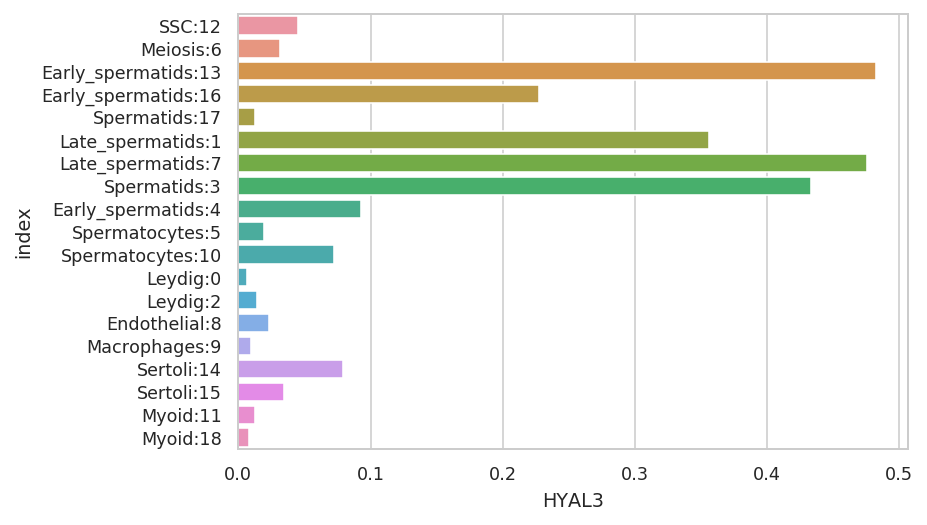

In [10]:
def plot_expression(gene):
    df = (scRNA_means
     .loc[lambda df: df['index'] == gene] 
     .set_index('index')
     .transpose()
     .reset_index()
     .assign(index=lambda df: pd.Categorical(df['index'], categories=cell_types, ordered=True))
    )
    sns.barplot(x=gene, y='index', data=df)

plot_expression("HYAL3")

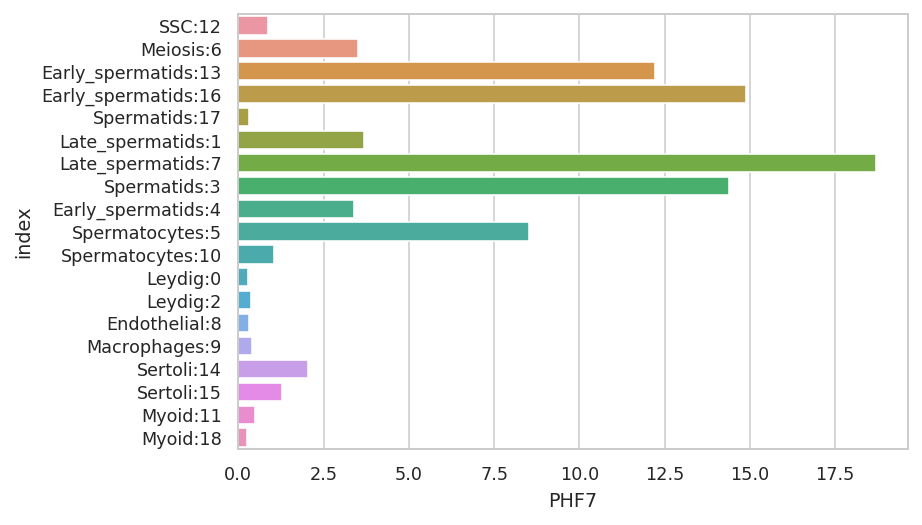

In [11]:
plot_expression("PHF7")

In [12]:
str(ag.data_dir / 'meritxell/umap_leiden_clusters.pdf')

'/home/kmt/simons/faststorage/people/kmt/data/meritxell/umap_leiden_clusters.pdf'

In [13]:
from IPython.display import Image, IFrame
from IPython.core.display import HTML
IFrame('../data/meritxell/umap_leiden_clusters.pdf', width=400, height=300)


## Genes with elevated expression in both placenta and testis

According to Human protein atlas

In [14]:
import mygene
from IPython.display import Markdown, display

from IPython.display import Image
from IPython.core.display import HTML 

mg = mygene.MyGeneInfo()

def gene_info(gene):
    top_hit = mg.query(gene, species='human', scopes='hgnc',
                       fields='symbol,alias,name,type_of_gene,summary,genomic_pos,genomic_pos_hg19')['hits'][0]

    tmpl = "**Symbol:** **_{symbol}_** "

    if 'type_of_gene' in top_hit:
        tmpl += "({type_of_gene})"
        
    if 'alias' in top_hit:
        if type(top_hit['alias']) is str:
            top_hit['aliases'] = top_hit['alias']
        else:
            top_hit['aliases'] = ', '.join(top_hit['alias'])
        tmpl += " &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** {aliases}"
    tmpl += '  \n'

    if 'name' in top_hit:
        tmpl += '*{name}*  \n'

    if 'summary' in top_hit:
        tmpl += "**Summary:** {summary}  \n"

    if 'genomic_pos' in top_hit and 'genomic_pos_hg19' in top_hit:
        if type(top_hit['genomic_pos']) is list:
            top_hit['hg38'] = ', '.join(['{chr}:{start}-{end}'.format(**d) for d in top_hit['genomic_pos']])
        else:
            top_hit['hg38'] = '{chr}:{start}-{end}'.format(**top_hit['genomic_pos'])
        if type(top_hit['genomic_pos_hg19']) is list:
            top_hit['hg19'] = ', '.join(['{chr}:{start}-{end}'.format(**d) for d in top_hit['genomic_pos_hg19']])
        else:
            top_hit['hg19'] = '{chr}:{start}-{end}'.format(**top_hit['genomic_pos_hg19'])            
        tmpl += "**Genomic position:** {hg38} (hg38), {hg19} (hg19)  \n"

    tmpl += "[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene={symbol})  \n".format(**top_hit)
    
    tmpl += "\n\n ----"
    
    display(Markdown(tmpl.format(**top_hit)))

In [15]:
genes = ['NAA11', 'CXorf67', 'RGPD1', 'TRIML2', 'TUBB1', 'MAGEA10', 'DPPA4', 
         'FAM184A', 'ATP1A4', 'CTAG2', 'IGDCC3', 'LHX8', 'HYAL4', 'ARMS2',
         'MKRN3', 'TCF15', 'IGF2BP1', 'L1TD1', 'TRIM58', 'DLX6', 'CTC-479C5.6', 
         'SH2D5', 'HBZ', 'MBNL3', 'TRIM60', 
         'CD300LG', 'ZIM2', 'DSCR4', 'PROK1', 'RGPD2', 'CLDN6', 'SH3TC2']

[gene_info(x) for x in genes]

**Symbol:** **_NAA11_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ARD1B, ARD2, hARD2  
*N-alpha-acetyltransferase 11, NatA catalytic subunit*  
**Genomic position:** 4:79225694-79326061 (hg38), 4:80146848-80247204 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NAA11)  


 ----

**Symbol:** **_EZHIP_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CATACOMB, CXorf67, KIP75  
*EZH inhibitory protein*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=EZHIP)  


 ----

**Symbol:** **_RGPD1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** RGP1, RGPD2, RanBP2L2  
*RANBP2 like and GRIP domain containing 1*  
**Genomic position:** 2:86907953-87013976 (hg38), 2:87135076-87241104, 2:88055474-88285309 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=RGPD1)  


 ----

**Symbol:** **_TRIML2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** SPRYD6  
*tripartite motif family like 2*  
**Summary:** This gene encodes a member of the tri-partite motif (TRIM) family of proteins. This protein may be regulated by the tumor suppressor p53 and may regulate p53 through the enhancement of p53 SUMOylation. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Dec 2014].  
**Genomic position:** 4:188091273-188109603 (hg38), 4:189012427-189030757 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRIML2)  


 ----

**Symbol:** **_TUBB1_** (protein-coding)  
*tubulin beta 1 class VI*  
**Summary:** This gene encodes a member of the beta tubulin protein family. Beta tubulins are one of two core protein families (alpha and beta tubulins) that heterodimerize and assemble to form microtubules. This protein is specifically expressed in platelets and megakaryocytes and may be involved in proplatelet production and platelet release. A mutations in this gene is associated with autosomal dominant macrothrombocytopenia. Two pseudogenes of this gene are found on chromosome Y.[provided by RefSeq, Jul 2010].  
**Genomic position:** 20:59019254-59026654 (hg38), 20:57594309-57601709 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TUBB1)  


 ----

**Symbol:** **_MAGEA10_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CT1.10, MAGE10  
*MAGE family member A10*  
**Summary:** This gene is a member of the MAGEA gene family. The members of this family encode proteins with 50 to 80% sequence identity to each other. The promoters and first exons of the MAGEA genes show considerable variability, suggesting that the existence of this gene family enables the same function to be expressed under different transcriptional controls. The MAGEA genes are clustered at chromosomal location Xq28. They have been implicated in some hereditary disorders, such as dyskeratosis congenita. Alternative splicing results in multiple transcript variants. Read-through transcription also exists between this gene and the downstream melanoma antigen family A, 5 (MAGEA5) gene.[provided by RefSeq, Oct 2011].  
**Genomic position:** X:152133310-152138578 (hg38), X:151301782-151307033 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MAGEA10)  


 ----

**Symbol:** **_DPPA4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** 2410091M23Rik  
*developmental pluripotency associated 4*  
**Summary:** This gene encodes a nuclear factor that is involved in the maintenance of pluripotency in stem cells and essential for embryogenesis. The encoded protein has a scaffold-attachment factor A/B, acinus and PIAS (SAP) domain that binds DNA and is thought to modify chromatin. Mice with a homozygous knockout of the orthologous gene die during late embryonic development or within hours after birth. Knockout embryos are normal in size at embryonic day 18.5 but exhibit skeletal and lung tissue abnormalities. This gene, when mutated, is highly expressed in embryonal carcinomas, pluripotent germ cell tumors, and other cancers and is thought to play an important role in tumor progression. Multiple pseudogenes of this gene have been identified. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Feb 2017].  
**Genomic position:** 3:109326141-109337572 (hg38), 3:109044988-109056419 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DPPA4)  


 ----

**Symbol:** **_FAM184A_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** C6orf60  
*family with sequence similarity 184 member A*  
**Genomic position:** 6:118959763-119149387 (hg38), 6:119280928-119470552 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=FAM184A)  


 ----

**Symbol:** **_ATP1A4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ATP1A1, ATP1AL2  
*ATPase Na+/K+ transporting subunit alpha 4*  
**Summary:** The protein encoded by this gene belongs to the family of P-type cation transport ATPases, and to the subfamily of Na+/K+ -ATPases. Na+/K+ -ATPase is an integral membrane protein responsible for establishing and maintaining the electrochemical gradients of Na and K ions across the plasma membrane. These gradients are essential for osmoregulation, for sodium-coupled transport of a variety of organic and inorganic molecules, and for electrical excitability of nerve and muscle. This enzyme is composed of two subunits, a large catalytic subunit (alpha) and a smaller glycoprotein subunit (beta). The catalytic subunit of Na+/K+ -ATPase is encoded by multiple genes. This gene encodes an alpha 4 subunit. Alternatively spliced transcript variants encoding different isoforms have been identified. [provided by RefSeq, Jul 2008].  
**Genomic position:** 1:160151570-160186977 (hg38), 1:160121360-160156767 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ATP1A4)  


 ----

**Symbol:** **_CTAG2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CAMEL, CT2, CT6.2, CT6.2a, CT6.2b, ESO2, LAGE-1, LAGE2B  
*cancer/testis antigen 2*  
**Summary:** This gene encodes an autoimmunogenic tumor antigen that belongs to the ESO/LAGE family of cancer-testis antigens. This protein is expressed in a wide array of cancers including melanoma, breast cancer, bladder cancer and prostate cancer. This protein is also expressed in normal testis tissue. An alternative open reading frame product of this gene has been described in PMID:10399963. This alternate protein, termed CAMEL, is a tumor antigen that is recognized by melanoma-specific cytotoxic T-lymphocytes. Alternate splicing results in multiple transcript variants. [provided by RefSeq, Sep 2013].  
**Genomic position:** X:154651972-154653579 (hg38), HG1497_PATCH:153820440-153822047, X:153880246-153881853 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CTAG2)  


 ----

**Symbol:** **_IGDCC3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** HsT18880, PUNC  
*immunoglobulin superfamily DCC subclass member 3*  
**Genomic position:** 15:65327127-65378002 (hg38), 15:65619465-65670378 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IGDCC3)  


 ----

**Symbol:** **_LHX8_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** LHX7  
*LIM homeobox 8*  
**Summary:** The protein encoded by this gene is a member of the LIM homeobox family of proteins, which are involved in patterning and differentiation of various tissue types. These proteins contain two tandemly repeated cysteine-rich double-zinc finger motifs known as LIM domains, in addition to a DNA-binding homeodomain. This family member is a transcription factor that plays a role in tooth morphogenesis. It is also involved in oogenesis and in neuronal differentiation. This gene is a candidate gene for cleft palate, and it is also associated with odontoma formation. Alternative splicing of this gene results in multiple transcript variants. [provided by RefSeq, Jan 2012].  
**Genomic position:** 1:75128434-75161533 (hg38), 1:75594119-75627218 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LHX8)  


 ----

**Symbol:** **_HYAL4_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CSHY, HYAL-4  
*hyaluronidase 4*  
**Summary:** This gene encodes a protein which is similar in structure to hyaluronidases but lacks hyaluronidase activity. The encoded protein acts as a chondroitin-sulfate-specific endo-beta-N-acetylgalactosaminidase; that is, it exhibits hydrolytic activity toward chondroitin sulfate chains and degrades them into oligosaccharides. Proteoglycans are formed by the covalent linkage of chondroitin sulfate chains to protein. Proteoglycans are ubiquitous components of the extracellular matrix of connective tissues and are also found at the surface of many cell types where they participate in a variety of cellular processes such as cell proliferation, differentiation, migration, cell-cell recognition, extracellular matrix deposition, and tissue morphogenesis. The expression of this gene is highest in testes and placenta. [provided by RefSeq, Apr 2019].  
**Genomic position:** 7:123828983-123877481 (hg38), 7:123469037-123517532 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=HYAL4)  


 ----

**Symbol:** **_ARMS2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ARMD8  
*age-related maculopathy susceptibility 2*  
**Summary:** This gene encodes a small secreted protein specific to primates. This protein is a component of the choroidal extracellular matrix of the eye. Mutations in this gene are associated with age-related macular degeneration. [provided by RefSeq, Sep 2017].  
**Genomic position:** 10:122454653-122457352 (hg38), 10:124214169-124216868 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ARMS2)  


 ----

**Symbol:** **_MKRN3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CPPB2, D15S9, RNF63, ZFP127, ZNF127  
*makorin ring finger protein 3*  
**Summary:** The protein encoded by this gene contains a RING (C3HC4) zinc finger motif and several C3H zinc finger motifs. This gene is intronless and imprinted, with expression only from the paternal allele. Disruption of the imprinting at this locus may contribute to Prader-Willi syndrome. An antisense RNA of unknown function has been found overlapping this gene. [provided by RefSeq, Jul 2008].  
**Genomic position:** 15:23565674-23630075 (hg38), 15:23810454-23873064 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MKRN3)  


 ----

**Symbol:** **_TCF15_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** EC2, PARAXIS, bHLHa40  
*transcription factor 15*  
**Summary:** The protein encoded by this gene is found in the nucleus and may be involved in the early transcriptional regulation of patterning of the mesoderm. The encoded basic helix-loop-helix protein requires dimerization with another basic helix-loop-helix protein for efficient DNA binding. [provided by RefSeq, Jul 2008].  
**Genomic position:** 20:603797-610398 (hg38), 20:584441-591042 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TCF15)  


 ----

**Symbol:** **_IGF2BP1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CRD-BP, CRDBP, IMP-1, IMP1, VICKZ1, ZBP1  
*insulin like growth factor 2 mRNA binding protein 1*  
**Summary:** This gene encodes a member of the insulin-like growth factor 2 mRNA-binding protein family. The protein encoded by this gene contains four K homology domains and two RNA recognition motifs. It functions by binding to the mRNAs of certain genes, including insulin-like growth factor 2, beta-actin and beta-transducin repeat-containing protein, and regulating their translation. Two transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, May 2009].  
**Genomic position:** 17:48997385-49056145 (hg38), 17:47074774-47133012 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IGF2BP1)  


 ----

**Symbol:** **_L1TD1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ECAT11  
*LINE1 type transposase domain containing 1*  
**Genomic position:** 1:62194849-62212328 (hg38), 1:62660503-62678000 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=L1TD1)  


 ----

**Symbol:** **_TRIM58_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** BIA2  
*tripartite motif containing 58*  
**Genomic position:** 1:247857187-247880138 (hg38), 1:248020501-248041507 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRIM58)  


 ----

**Symbol:** **_DLX6_** (protein-coding)  
*distal-less homeobox 6*  
**Summary:** This gene encodes a member of a homeobox transcription factor gene family similiar to the Drosophila distal-less gene. This family is comprised of at least 6 different members that encode proteins with roles in forebrain and craniofacial development. This gene is in a tail-to-tail configuration with another member of the family on the long arm of chromosome 7. [provided by RefSeq, Jul 2008].  
**Genomic position:** 7:97005553-97011040 (hg38), 7:96634860-96640351 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DLX6)  


 ----

**Symbol:** **_DPEP2NB_** (protein-coding)  
*DPEP2 neighbor*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DPEP2NB)  


 ----

**Symbol:** **_SH2D5_** (protein-coding)  
*SH2 domain containing 5*  
**Genomic position:** 1:20719731-20732837 (hg38), 1:21046225-21059330 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SH2D5)  


 ----

**Symbol:** **_HBZ_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** HBAZ, HBZ-T1, HBZ1  
*hemoglobin subunit zeta*  
**Summary:** Zeta-globin is an alpha-like hemoglobin. The zeta-globin polypeptide is synthesized in the yolk sac of the early embryo, while alpha-globin is produced throughout fetal and adult life. The zeta-globin gene is a member of the human alpha-globin gene cluster that includes five functional genes and two pseudogenes. The order of genes is: 5' - zeta - pseudozeta - mu - pseudoalpha-1 - alpha-2 -alpha-1 - theta1 - 3'. [provided by RefSeq, Nov 2009].  
**Genomic position:** 16:142728-154503 (hg38), 16:202686-204502 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=HBZ)  


 ----

**Symbol:** **_MBNL3_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CHCR, MBLX, MBLX39, MBXL  
*muscleblind like splicing regulator 3*  
**Summary:** This gene encodes a member of the muscleblind-like family of proteins. The encoded protein may function in regulation of alternative splicing and may play a role in the pathophysiology of myotonic dystrophy. Alternatively spliced transcript variants have been described. [provided by RefSeq, Dec 2009].  
**Genomic position:** X:132369317-132489968 (hg38), X:131503345-131623996 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MBNL3)  


 ----

**Symbol:** **_TRIM60_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** RNF129, RNF33  
*tripartite motif containing 60*  
**Summary:** The protein encoded by this gene contains a RING finger domain, a motif present in a variety of functionally distinct proteins and known to be involved in protein-protein and protein-DNA interactions. Pseudogenes of this gene are located on more than six chromosomes including chromosome 4. Multiple alternatively spliced variants, encoding the same protein, have been identified. [provided by RefSeq, Jan 2013].  
**Genomic position:** 4:165016458-165041749 (hg38), 4:165953105-165962896 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRIM60)  


 ----

**Symbol:** **_CD300LG_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CLM-9, CLM9, NEPMUCIN, TREM-4, TREM4  
*CD300 molecule like family member g*  
**Summary:** Members of the CD300 (see MIM 606786)-like (CD300L) family, such as CD300LG, are widely expressed on hematopoietic cells. All CD300L proteins are type I cell surface glycoproteins that contain a single immunoglobulin (Ig) V-like domain (Takatsu et al., 2006 [PubMed 16876123]).[supplied by OMIM, Mar 2008].  
**Genomic position:** 17:43847148-43863639 (hg38), 17:41924516-41940997 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CD300LG)  


 ----

**Symbol:** **_ZIM2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** ZNF656  
*zinc finger imprinted 2*  
**Summary:** In human, ZIM2 and PEG3 (GeneID:5178) are two distinct genes that share a set of 5' exons and have a common promoter, and both genes are paternally expressed. Alternative splicing events connect the shared exons either with the remaining 4 exons unique to ZIM2, or with the remaining 2 exons unique to PEG3. This is in contrast to mouse and cow, where ZIM2 and PEG3 genes do not share exons in common, and the imprinting status of ZIM2 is also not conserved amongst mammals. Additional 5' alternatively spliced transcripts encoding the same protein have been found for the human ZIM2 gene. [provided by RefSeq, Oct 2010].  
**Genomic position:** 19:56774547-56840729 (hg38), 19:57285920-57352097 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ZIM2)  


 ----

**Symbol:** **_DSCR4_**   
*Down syndrome critical region 4*  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DSCR4)  


 ----

**Symbol:** **_PROK1_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** EGVEGF, PK1, PRK1  
*prokineticin 1*  
**Summary:** The protein encoded by this gene induces proliferation, migration, and fenestration (the formation of membrane discontinuities) in capillary endothelial cells derived from endocrine glands. It has little or no effect on a variety of other endothelial and non-endothelial cell types. Its expression is restricted to the steroidogenic glands (ovary, testis, adrenal, and placenta), is induced by hypoxia, and often complementary to the expression of vascular endothelial growth factor (VEGF), suggesting that these molecules function in a coordinated manner. [provided by RefSeq, Sep 2011].  
**Genomic position:** 1:110451149-110457358 (hg38), 1:110993822-110999976 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PROK1)  


 ----

**Symbol:** **_RGPD2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** NUP358, RANBP2L2, RGP2  
*RANBP2 like and GRIP domain containing 2*  
**Genomic position:** 2:87755960-87825952 (hg38), 2:88055474-88285309 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=RGPD2)  


 ----

**Symbol:** **_CLDN6_** (protein-coding)  
*claudin 6*  
**Summary:** Tight junctions represent one mode of cell-to-cell adhesion in epithelial or endothelial cell sheets, forming continuous seals around cells and serving as a physical barrier to prevent solutes and water from passing freely through the paracellular space. These junctions are comprised of sets of continuous networking strands in the outwardly facing cytoplasmic leaflet, with complementary grooves in the inwardly facing extracytoplasmic leaflet. This gene encodes a component of tight junction strands, which is a member of the claudin family. The protein is an integral membrane protein and is one of the entry cofactors for hepatitis C virus. The gene methylation may be involved in esophageal tumorigenesis. This gene is adjacent to another family member CLDN9 on chromosome 16.[provided by RefSeq, Aug 2010].  
**Genomic position:** 16:3014712-3020071 (hg38), 16:3064713-3070072 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CLDN6)  


 ----

**Symbol:** **_SH3TC2_** (protein-coding) &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** CMT4C, MNMN  
*SH3 domain and tetratricopeptide repeats 2*  
**Summary:** This gene encodes a protein with two N-terminal Src homology 3 (SH3) domains and 10 tetratricopeptide repeat (TPR) motifs, and is a member of a small gene family. The gene product has been proposed to be an adapter or docking molecule. Mutations in this gene result in autosomal recessive Charcot-Marie-Tooth disease type 4C, a childhood-onset neurodegenerative disease characterized by demyelination of motor and sensory neurons. [provided by RefSeq, Jul 2008].  
**Genomic position:** 5:148923639-149063163 (hg38), 5:148303202-148442726 (hg19)  
[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SH3TC2)  


 ----

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]